# Electricity Price Clustering Analysis
**Objective:** Analyze the stability of electricity prices over a 1-year period

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tslearn.clustering import TimeSeriesKMeans

import pandas as pd
raw_data = pd.read_csv('dataset_dollarhide.csv')

### Observations:
* Data is ordered by entry date from the period of Oct 2019 - Oct 2020 at 0, 15, 30, 45 minute marks (not all data points for each quarter hour is reported)
* Prices range from -1628.823333 to 5538.150000
* Assumptions:
    * Prices were collected from same source so no standardization or rescaling is needed
    * Every day's time series is represented by a $96 \times 1$-vector that has all of the prices for that day
    * A cluster is a group of days with similar trend
    

In [24]:
# First look at raw data
raw_data.head()

,entry_date,rounded_time,price,lmp_westzn,load_value,wind_generation,online_price_adder,surface_temperature,relative_humidity,surface_dewpoint_temperature,wind_chill_temperature,wind_speed,dam_price
0,10/28/2019,15:15:00,22.636667,22.353333,1270.4350,5142.470000,0.000000,5.475,65.850,-0.375,1.880553,18.35,-1.13
1,10/28/2019,15:30:00,23.283333,22.996667,1266.5600,4804.793333,0.000167,5.850,64.400,-0.350,2.543709,16.90,-1.13
2,10/28/2019,15:45:00,23.420000,23.126667,1262.6850,4507.700000,0.000200,6.225,62.950,-0.325,3.206865,15.45,-1.13
3,10/28/2019,16:00:00,27.280000,26.933333,1258.8100,4315.153333,0.001067,6.600,61.500,-0.300,3.870021,14.00,2.81
4,10/28/2019,16:15:00,25.953333,25.623333,1256.0125,4093.573333,0.000567,6.975,60.525,-0.125,4.381897,13.65,2.81


In [25]:
# Combine date and time columns and convert to datetime format for easier handling
raw_data['datetime']=pd.to_datetime(raw_data['entry_date'] + ' ' + raw_data['rounded_time'])

In [26]:
# Create a dataframe object with only the datetime and price columns
df = raw_data.loc[:, ['price']]
df = df.set_index(raw_data.datetime) #set the date as index
df.head()

,price
datetime,
2019-10-28 15:15:00,22.636667
2019-10-28 15:30:00,23.283333
2019-10-28 15:45:00,23.420000
2019-10-28 16:00:00,27.280000
2019-10-28 16:15:00,25.953333


In [27]:
df.describe()

,price
count,35179.000000
mean,-12.371245
std,315.017199
min,-1628.823333
25%,9.058333
50%,15.476667
75%,19.330000
max,5538.150000


### Handling missing values and cleaning data
* Price column has 14 missing values. 
* One way to handle missing values is to simply ignore them. This is acceptable since not all data points for every 15-minute interval are available in the original dataset.
* An alternative is to impute the missing values using a descriptive statistics (mean, median, mode) or backward/forward fill. However, the prices do not seem to follow any discernible trend chronologically. Additional analysis of the other columns is probably a good way to predict the prices of the missing values. 
* For this analysis, I will just ignore the missing values and leave them as NaNs.
* I will also add the unreported data points so each time series will have equal size ($96 \times 1$ vectors).
* Later on, I found a duplicate entry that gave me a lot troubles with plotting the charts so I went back and removed it in this section.

In [28]:
# Find all of the missing entries
print(df.isnull().sum())
print(df.shape)
print(df[df.isna().any(axis=1)])

price    14
dtype: int64
(35193, 1)
                     price
datetime                  
2019-11-08 10:30:00    NaN
2019-11-08 10:45:00    NaN
2019-11-08 11:00:00    NaN
2019-11-08 11:15:00    NaN
2019-11-09 11:45:00    NaN
2019-11-16 11:45:00    NaN
2019-12-04 16:45:00    NaN
2019-12-04 17:00:00    NaN
2019-12-06 11:45:00    NaN
2019-12-10 22:45:00    NaN
2019-12-17 16:45:00    NaN
2019-12-17 17:00:00    NaN
2019-12-21 10:30:00    NaN
2019-12-29 12:30:00    NaN


In [29]:
# Find all the days that have missing times (less than 96 entries)
day = df.resample('D').count()
day[day['price'] < 96]

,price
datetime,
2019-10-28,35
2019-11-08,92
2019-11-09,95
2019-11-16,95
2019-12-04,94
2019-12-06,95
2019-12-10,95
2019-12-17,94
2019-12-21,95


In [30]:
#There's a duplicate entry for timestamp 2020-05-20 19:15:00.
df[df.index.duplicated()]

,price
datetime,
2020-05-20 19:15:00,20.333333


In [31]:
df_filled = df[~df.index.duplicated(keep='first')] #Remove duplicate

In [32]:
# Add missing timestamps for all dates
dates = pd.date_range(start=pd.Timestamp('2019-10-28 00:00:00'), end=pd.Timestamp('2020-10-30 23:45:00'), freq='15Min')
# print(dates)

df_filled = df_filled.reindex(dates) 
# df_filled.head(96)
df_filled.index.name = 'datetime'

### Initial Visualization

The data seems to be quite volatile between 2019-10 to 2020-05.

Text(0.5, 0.98, 'Graph 1: Electricity Prices from Oct 2019 - 2020')

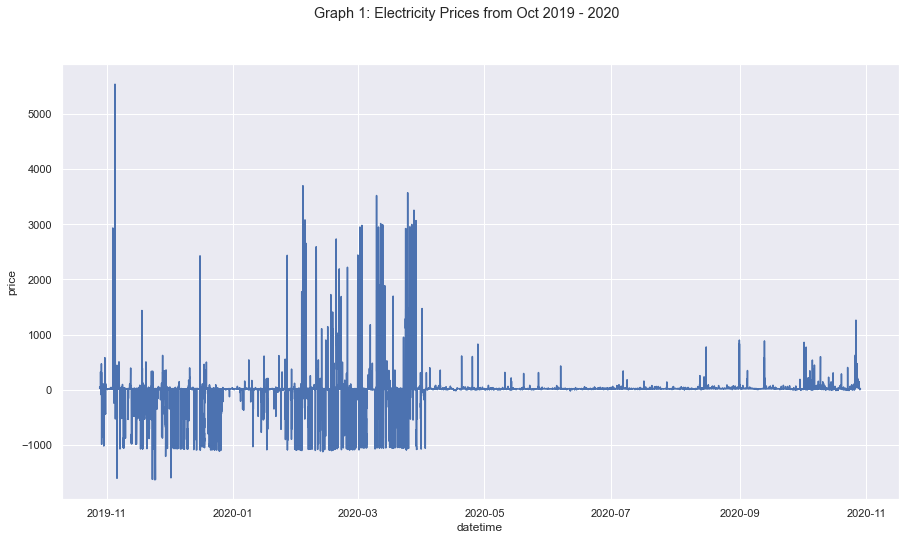

In [33]:
# First look at the raw data
figure, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x='datetime', y='price', data=df, ax=ax)
figure.suptitle('Graph 1: Electricity Prices from Oct 2019 - 2020')

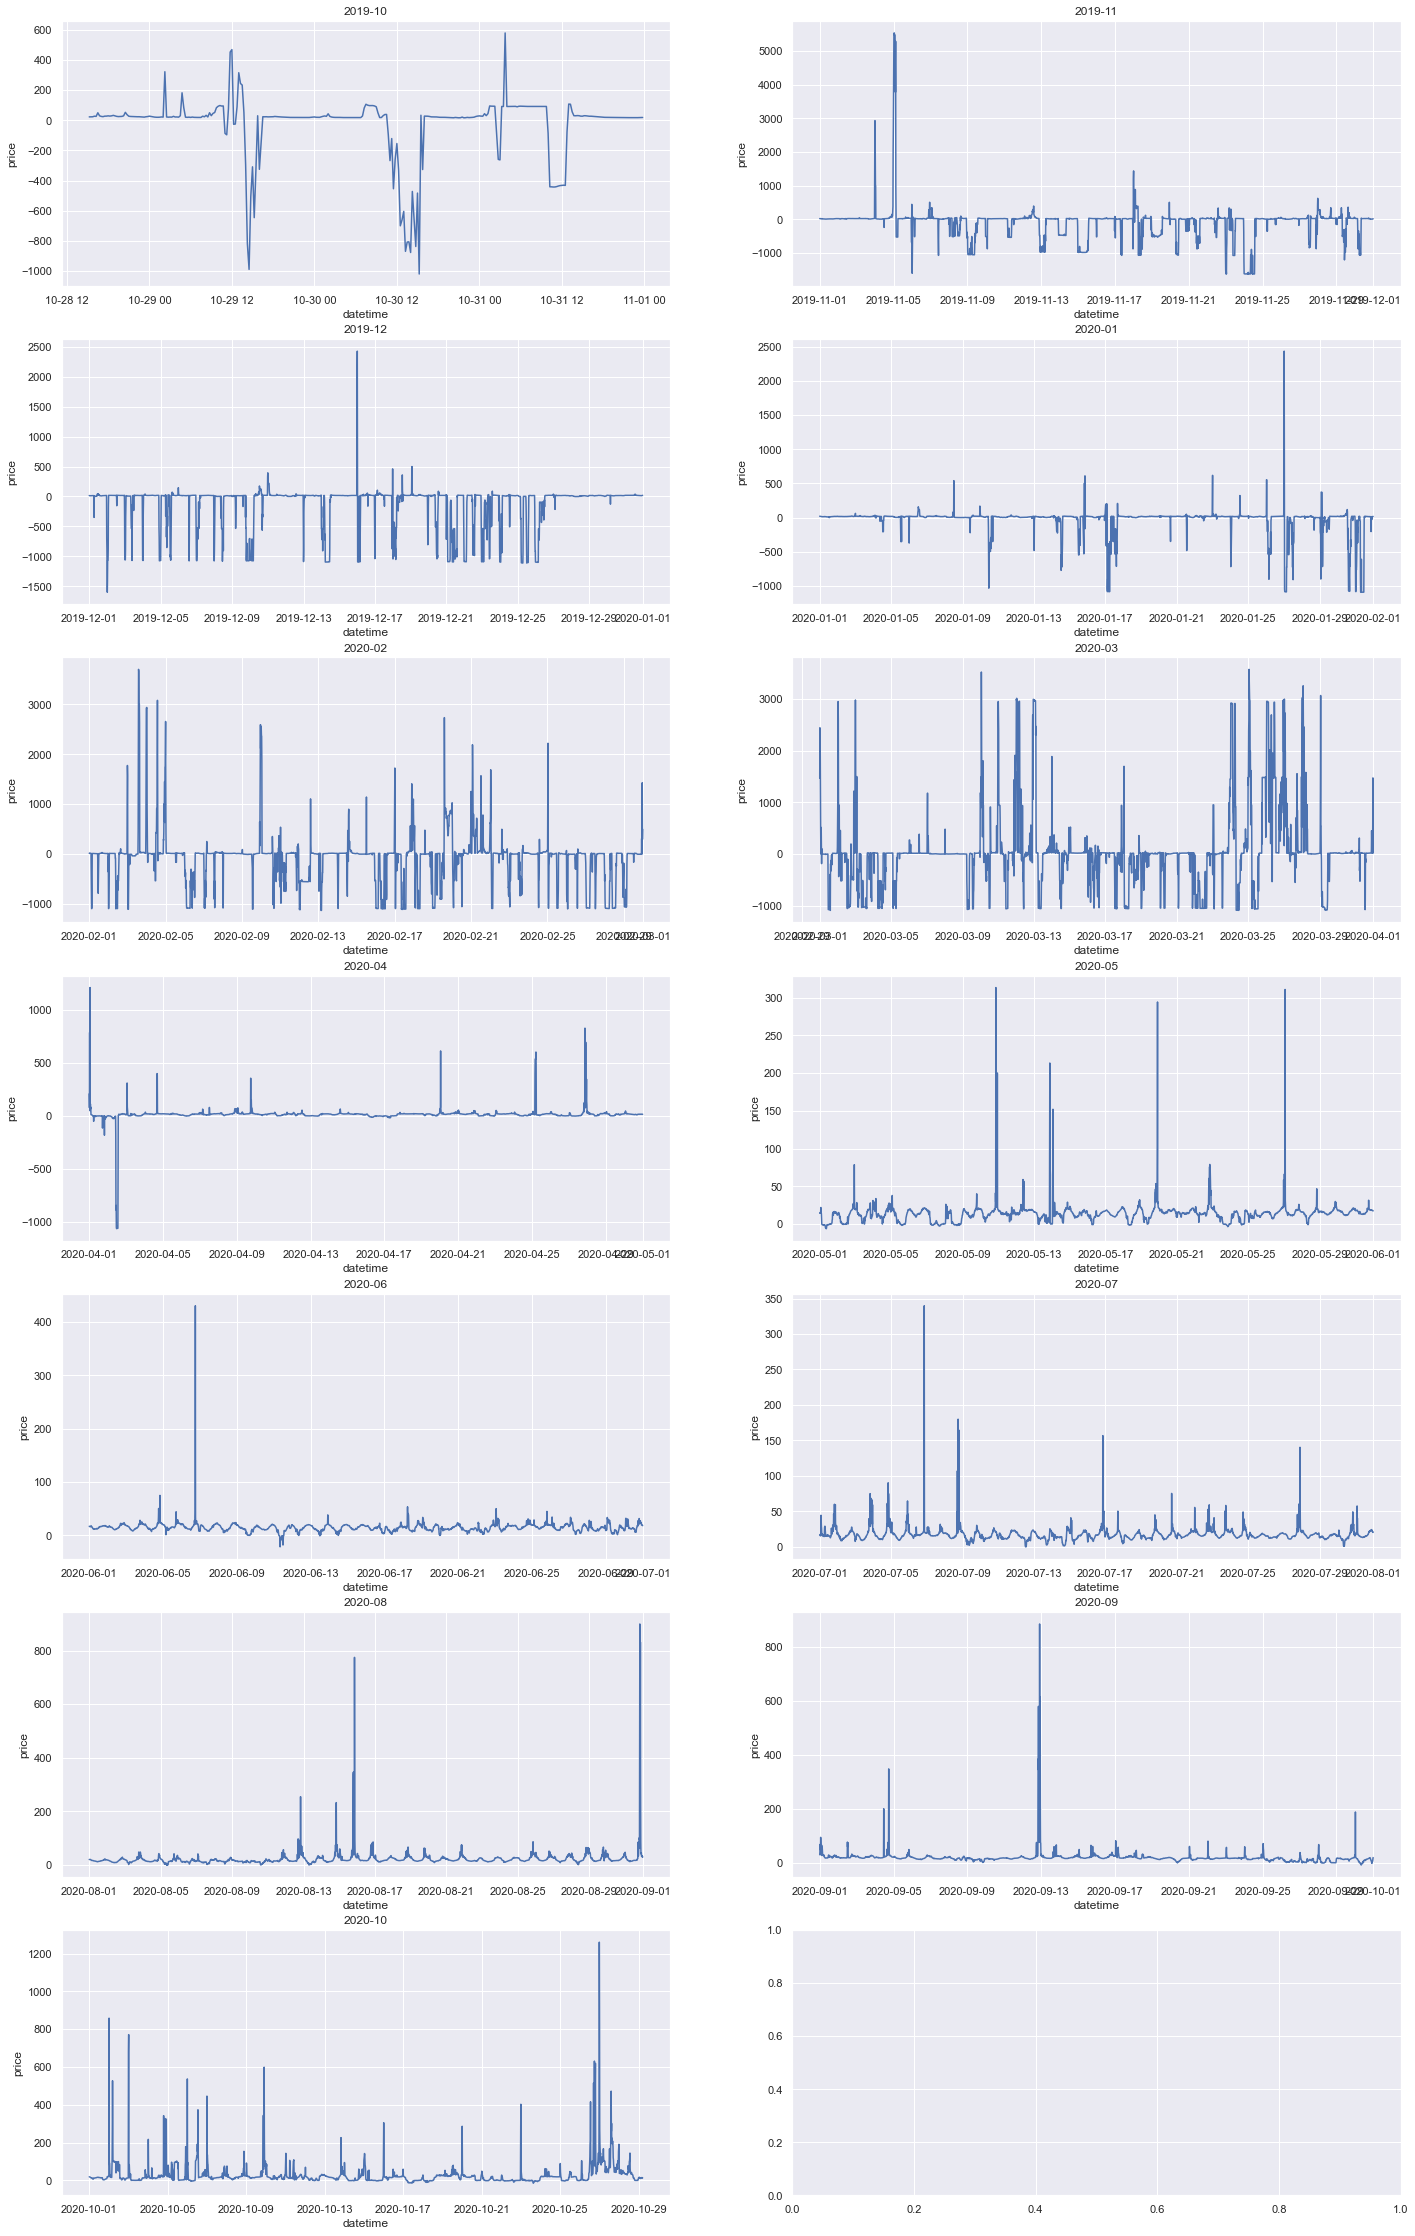

In [34]:
# Look at the trends of each month
months = ['2019-10', '2019-11', '2019-12', '2020-01', '2020-02', 
          '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', 
          '2020-08', '2020-09', '2020-10']

figure, ax = plt.subplots(7, 2, figsize=(24, 40))
ax = ax.flatten()
for i in range(len(months)):
    drange = df.loc[months[i]]
    sns.lineplot(data = drange['price'], ax=ax[i])
    ax[i].set_title(months[i])

### Clustering:

**Method:**
* Partition the data from the Oct 19 - Mar 20 (first 6 months) into 6 clusters (representing the "types of day") by using k-means with DTW as the similarity measurement  
* Repeatedly shift the six-month window by one week and recompute the 6 clusters to create 26 snapshots in total

The commonly used Euclidian distance does not work well with time-series data because it will produce pessimistic similarity measurement due to the time axis distortion. **Dynamic Time Warping (DTW)** is a better choice to find the optimal non-linear alignment between two time series. 

DTW is computed using dynamic programming with $O(n^2)$. Although more accurate, the tradeoff is DTW's quadratic time complexity does not scale well to large dataset. Consider the size of the our dataset, using DTW here is acceptable.  

I used k-means and DTW here because it's easier to implement. If I had more time, I'd like to explore a few more clustering algorithms and compare their performances. For example, **k-DBA, k-spectral centroid, and hierarchical clustering** would also be applicable clustering techniques for this problem.  

A more involved approach is to try **feature-based clustering** methods, in which we will try to extract feature representation of input time series. This will help mitigate the impact of noise and outliers while also reducing the dimensionality of the data. This paper presents an interesting way to leverage the seq2seq model to extract features from time series data. https://proceedings.neurips.cc/paper/2019/file/1359aa933b48b754a2f54adb688bfa77-Paper.pdf

In [35]:
# Prepare data for k-means. TimeSeriesKMeans will automatically fill in NaN for missing vals
df2 = raw_data.loc[:, ['price', 'entry_date']]
df2 = df2.set_index(raw_data.datetime)

In [36]:
df2.head()

,price,entry_date
datetime,,
2019-10-28 15:15:00,22.636667,10/28/2019
2019-10-28 15:30:00,23.283333,10/28/2019
2019-10-28 15:45:00,23.420000,10/28/2019
2019-10-28 16:00:00,27.280000,10/28/2019
2019-10-28 16:15:00,25.953333,10/28/2019


In [54]:
# Convert dataframe into list
def series_to_list(ls):
    seen = set()
    seen.add(ls[0][1])
    
    mySeries = []
    curr = []
    for price, date in ls:
        if date in seen:
            curr.append(price)
        else:
            mySeries.append(curr)
            curr = [price]
            seen.add(date)
    return mySeries

In [61]:
from datetime import date, timedelta
from tslearn.utils import to_time_series_dataset

model = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10)

start = date.fromisoformat('2019-10-28')
end = date.fromisoformat('2020-03-27')
res = []
count = 1

while count <= 26:
    # Get the dataframe for the 6-month snapshot
    six_month = df2.loc[start : end]
    six_month = six_month.set_index(six_month.entry_date)
    six_month.drop(['entry_date'], axis=1)

    # Format dataframe and convert to correct array format for tslearn
    ls = six_month.values.tolist()
    mySeries = series_to_list(ls)
    formatted_time_series = to_time_series_dataset(mySeries)
    
    # Fit k-means with DTW to find clusters
    labels = model.fit_predict(formatted_time_series)
    res.append(labels)
    
    # Shift by one week
    start += timedelta(days=7)
    end += timedelta(days=7)
    count += 1

In [63]:
# cluster labels for every day in each snapshot
res

[array([2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0,
        2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0]),
 array([2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2

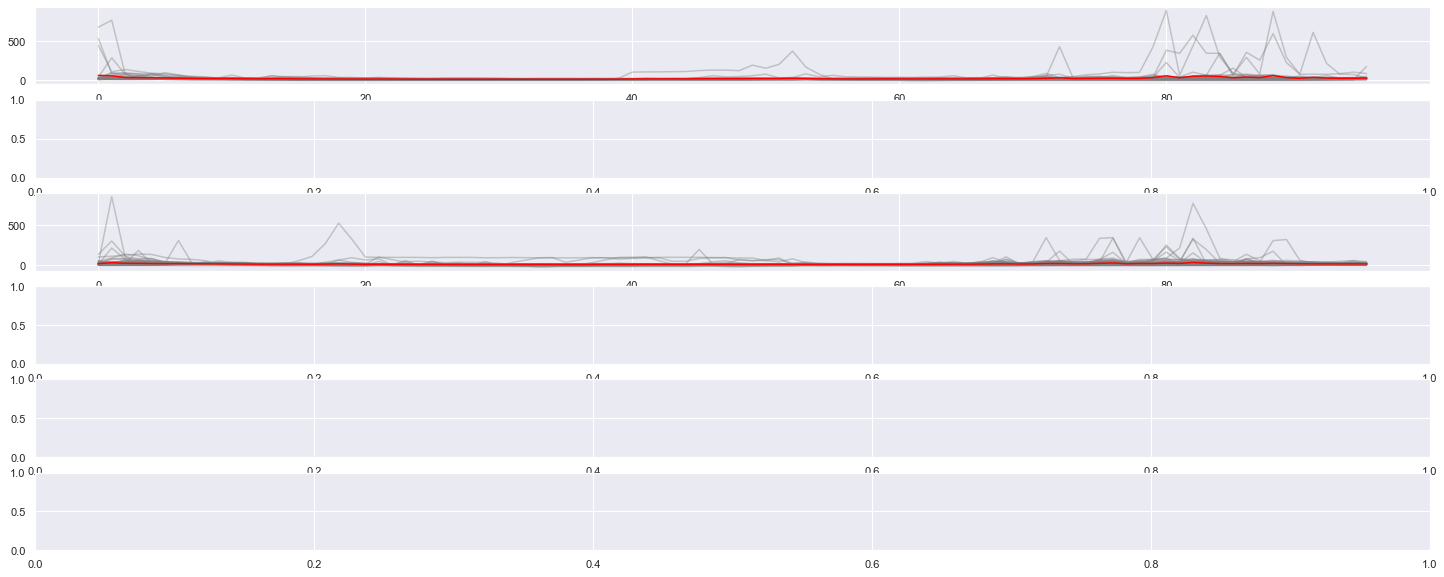

In [641]:
# TODO: Plotting code is still buggy. I still need to format and resize the input data 
# the right way that matplotlib wants before I can plot this. 


# import numpy as np


# fig, axs = plt.subplots(6, 1, figsize=(25, 10))
# axs = axs.flatten()
# row_i=0
# column_j=0

# for label in range(6):
#     cluster = []
#     for i in range(len(labels1)):
#         if labels1[i] == label:
#             axs[label].plot(mySeries[i], c="gray",alpha=0.4)
#             cluster.append(mySeries[i])
#     if len(cluster) > 0:
#         axs[label].plot(np.average(np.vstack(cluster),axis=0),c="red")

# plt.show()

###  (TODO) Stability Analysis:
After generating the snapshots for the 6 clusters, I now need to determine which one is the same or new cluster in each snapshot.

One possible approach is to check by hand the **membership** of each cluster. Since we're shifting each snapshot by one week, there should be overlaps between every two snapshots. We can look for the common members and track the clusters that way. Of course, this might be not reliable because by removing and adding data for each snapshot, the clusters could have changed. For example, suppose the new data is in between the borders of two clusters, this might cause the reorganization of these two clusters and nearby clusters. 

Perhaps a more robust option is to take a step further and try to characterize the clusters at each snapshot. We can try to do **projection** on the clusters, treating each one as a high-dimensional group of data and use a dimensionality reduction technique to characterize it, for example using **PCA**. We can also try an **autoencoder** to learn the latent variables of each cluster. I'm not quite sure yet what is the best similarity metrics to compare and associate the clusters. 

Another idea is to do **adaptive clustering**. Instead of taking discrete snapshots of the data, we can try to start with an initial set of clusters, add new data, and observe how that data affects the existing clustering. The data can be added to an existing cluster or  its own new cluster if it exceeds a certain threshold. 